# Init Step

## import library

In [1]:
import tensorflow as tf
import keras as K
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import os
import pathlib
import utils

2024-06-08 22:15:15.608802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## variables

In [2]:
height, width = 224, 224
fps = 4
n_classes = 9
# savePath = "./data/cropHand_fps4/"
splitedFolder = "color_fps4_splited_dataset"



# Preprocessing of images dataset

In [3]:
import os
cwd = os.getcwd()
print("current dir: {}".format(cwd))

current dir: /Users/mika/FYP/development/handGesture_FYP/model


In [4]:
# directory of the images dataset
base_dir = Path('../data')
data_dir = base_dir/ splitedFolder
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

# variable for model parameter 
n_epochs = 11
n_train_samples = utils.count_jpgs(train_dir)
n_val_samples = utils.count_jpgs(val_dir)
batch_size = 32

In [5]:
# data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(height,width))
val_generator = train_datagen.flow_from_directory(val_dir, target_size=(height,width))

test_datagen = ImageDataGenerator(rescale=1./255) #use the original image for testing
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(height,width))

Found 9838 images belonging to 9 classes.
Found 3282 images belonging to 9 classes.
Found 3273 images belonging to 9 classes.


In [6]:
import utils
from keras.applications import VGG16
# load pretrained model and weights
conv_layers = VGG16(weights = 'imagenet', include_top=False, input_shape=(height,width,3))
conv_layers.trainable = False
print('per-trained model has been loaded')
conv_layers.summary()



per-trained model has been loaded
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2

In [7]:
# pretraind model
model = K.models.Sequential()
model.add(conv_layers)
model.add(K.layers.Flatten())

# new layers
model.add(K.layers.Dense(256, activation='relu')) 
model.add(K.layers.Dropout(0.5)) # dropout layer to reduce overfitting
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))

model.add(K.layers.Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 9)                 2

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch=n_train_samples/batch_size,
                    epochs=n_epochs,
                    validation_data=val_generator,
                    validation_steps=n_val_samples/batch_size,
                    verbose=2,
                    shuffle=True,
                    )


Epoch 1/11


249/249 - 582s - loss: 1.0738 - acc: 0.6260 - val_loss: 0.0402 - val_acc: 0.9944 - 582s/epoch - 2s/step
Epoch 2/11
249/249 - 574s - loss: 0.4546 - acc: 0.8152 - val_loss: 0.0143 - val_acc: 0.9981 - 574s/epoch - 2s/step
Epoch 3/11
249/249 - 574s - loss: 0.4182 - acc: 0.8354 - val_loss: 0.0068 - val_acc: 0.9981 - 574s/epoch - 2s/step
Epoch 4/11
249/249 - 574s - loss: 0.3555 - acc: 0.8564 - val_loss: 0.0140 - val_acc: 0.9966 - 574s/epoch - 2s/step
Epoch 5/11
249/249 - 575s - loss: 0.3737 - acc: 0.8509 - val_loss: 0.0049 - val_acc: 0.9992 - 575s/epoch - 2s/step
Epoch 6/11
249/249 - 574s - loss: 0.3517 - acc: 0.8610 - val_loss: 0.0062 - val_acc: 0.9992 - 574s/epoch - 2s/step
Epoch 7/11
249/249 - 577s - loss: 0.3411 - acc: 0.8658 - val_loss: 0.0046 - val_acc: 0.9996 - 577s/epoch - 2s/step
Epoch 8/11
249/249 - 572s - loss: 0.3423 - acc: 0.8603 - val_loss: 0.0104 - val_acc: 0.9989 - 572s/epoch - 2s/step
Epoch 9/11
249/249 - 571s - loss: 0.3291 - acc: 0.8722 - val_loss: 0.0062 - v

In [9]:
model.save(splitedFolder + ".h5")

c:\Users\mkhung6\AppData\Local\anaconda3\envs\mediapipe\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# show the accuracy of the model

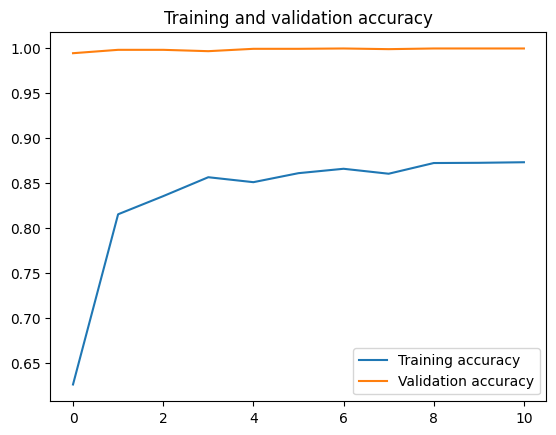

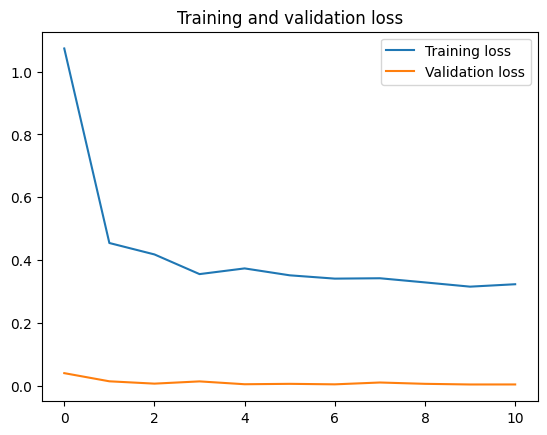

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
import utils
import json
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}
print(class_indices)
config = {
        'indices': class_indices, 
        'input_size': (height, width)
    }
fp = splitedFolder + '.json'
with open(fp, 'w', encoding='UTF-8') as f:
    json.dump(config, f,ensure_ascii=False)

{0: 'ChanDingYin', 1: 'HuoYanYin', 2: 'MiTuoDingYin', 3: 'Retsu', 4: 'Rin', 5: 'TaiJiYin', 6: 'Zai', 7: 'Zen', 8: 'ZhiJiXiangYin'}


current dir: /Users/mika/FYP/development/handGesture_FYP/model
102/102 [==============================] - 456s 4s/step - loss: 0.4737 - acc: 0.8506
test acc: 0.8506
Found 3273 images belonging to 9 classes.
103/103 [==============================] - 446s 4s/step
[[293   0   0   0   0  49   0   0  25]
 [  0 408   0   0   0   0   0   0   0]
 [  0   1 321   0   0  63   0   0  15]
 [  0  58   0 256   0   1   0   0  18]
 [  2  58   2   0 230   2   3   1  10]
 [  0   0   0   0   0 382   0   0  32]
 [  0  35   0   0   0   0 291   0   8]
 [  0  48   0   0   0   4   0 256   9]
 [  0   0   2   0   0  43   0   0 347]]


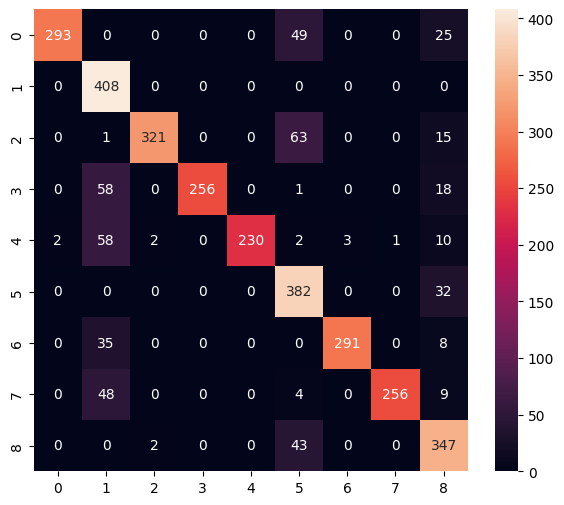

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       367
           1       0.67      1.00      0.80       408
           2       0.99      0.80      0.89       400
           3       1.00      0.77      0.87       333
           4       1.00      0.75      0.86       308
           5       0.70      0.92      0.80       414
           6       0.99      0.87      0.93       334
           7       1.00      0.81      0.89       317
           8       0.75      0.89      0.81       392

    accuracy                           0.85      3273
   macro avg       0.90      0.84      0.86      3273
weighted avg       0.89      0.85      0.86      3273



In [7]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
#test the accuracy on test set
cwd = os.getcwd()
print("current dir: {}".format(cwd))

model = tf.keras.models.load_model(splitedFolder+".h5")
n_test_set = utils.count_jpgs(test_dir)
_, test_acc = model.evaluate(test_generator, steps=n_test_set/batch_size)
print('test acc: {:.4f}'.format(test_acc))


test_datagen = ImageDataGenerator(rescale=1./255 ) #use the original image for testing
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(height,width), shuffle=False)

#calculate the confusion matrix of the model on test set
y_true = test_generator.classes

# Use the model to predict the labels of the test set
y_pred = model.predict(test_generator)
# Convert predictions to label indices
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix of prediction and actual class
cm = confusion_matrix(y_true, y_pred)

print(cm)
labels = train_generator.class_indices.values()
df_cmx = pd.DataFrame(cm, index=labels, columns=labels)
 
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
ax.set_ylim(len(set(y_true)), 0)
plt.show()


print('Classification Report')
print(classification_report(y_true, y_pred))




In [10]:
import utils
GESTURES = {
        "0": "ChanDingYin",
        "1": "HuoYanYin",
        "2": "MiTuoDingYin",
        "3": "Retsu",
        "4": "Rin",
        "5": "TaiJiYin",
        "6": "Zai",
        "7": "Zen",
        "8": "ZhiJiXiangYin"}
for g in GESTURES.values():
    num = utils.count_jpgs(test_dir/g)
    print(f"The number image in test set of {g} is:", num)



The number image in test set of ChanDingYin is: 367
The number image in test set of HuoYanYin is: 408
The number image in test set of MiTuoDingYin is: 400
The number image in test set of Retsu is: 333
The number image in test set of Rin is: 308
The number image in test set of TaiJiYin is: 414
The number image in test set of Zai is: 334
The number image in test set of Zen is: 317
The number image in test set of ZhiJiXiangYin is: 392


In [55]:
import utils
import json
import pandas as pd
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}
# hist_df = pd.DataFrame(history.history)

config = {
        'indices': class_indices, 
        'input_size': (height, width),
        'confusion_matrix': np.array2string(cm),
        'test_acc': test_acc,
        'history':history.history
        
    }

fp = splitedFolder + '.json'
with open(fp, 'w', encoding='UTF-8') as f:
    json.dump(config, f,ensure_ascii=False)
    # hist_df.to_json(f)
    